# McStasScript introduction
This notebook shows how to use McStas and McStasScript to perform a basic simulation of a neutron diffractometer. The following software is required:
- McStas (www.mcstas.org)
- McStasScript (can be installed with python -m pip install McStasScript)

### Anatomy of a McStas instrument

In McStas a simulation is described using an instrument file. Such an instrument has five sections where code can be added to define the simulation to be perfomed.

- Instrument definition
- Declare section
- Initialize section
- Trace section
- Finally section

##### Instrument definition
In the instrument definition it is possible to define *instrument parameters* which can be specified at run time and used in the remaining sections for either calculations or as direct input to the components.

##### Declare section
Here internal variables can be declared with C syntax.

##### Initialize section
The initialize section is used for performing calculations, typically using both instrument parameters and declared variables to calculate for example chopper phases, angles and similar. The calculations are performed using C syntax. These calculations are performed before the raytracing simulation, and thus only performed once in a given simulation.

##### Trace section
In the trace section McStas *components* are added, these are the building blocks of the simulation and correspond to different c codes that describe parts of neutron instruments or samples. Each component have a set of available parameters, some of which may be required. These will set the behavior of a component, a guide component may for example have parameters describing the physical shape and mirror reflectivity. Components also need to be placed in 3D space, and can be placed either in the absolute coordinate system or relative to a previously defined component.

##### Finally section
The finally section is very similar to the initialize section, here calculations can be performed after the raytracing has been completed, again using C syntax. This may be some brief data analysis or print of some status.

### McStasScript python package and this tutorial
The McStasScript python package provides an API to build and run such instruments files, but it is still necessary to have a basic understanding of the structure of the underlying instrument file and its capabilities and limitations. These tutorials will teach basic use of McStas through the McStasScript API without assuming expertise in the underlying McStas software.

### Import the McStasScript package
The McStasScript modules intended for normal use is located in the interface submodule, and one usually imports the necessary modules from there.

In [1]:
from mcstasscript.interface import instr, functions, plotter

### McStasScript configuration
Before the first use of McStasScript it is necessary to configure the package so it can locate the McStas installation and call the binaries. One way to find the path is to open a terminal with the McStas environment and run:

which mcrun

This should return the path for the binary, and the mcstas path is usually just one step back.

In [2]:
configurator = functions.Configurator()
configurator.set_mcrun_path("/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1/bin/")
configurator.set_mcstas_path("/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1")

### Create an instrument object
A McStas instrument is described with a McStas instrument object which is created using the *McStas_instr* method on the instr class. Creating an instrument object also reads available components, both in the work folder and from the McStas installation. By default, the work folder is the current work directory, but using the input_path keyword argument this can be change to avoid cluttering the folder containing notebooks.

Here our instrument object for this tutorial is created, we give it the name python_tutorial.

In [3]:
instrument = instr.McStas_instr("python_tutorial", input_path="run_folder")

### Requesting help on source components
The main building blocks used for creating a McStas simulation are the components. One can ask an instrument object which components are available, and get help for each component. Here we check what sources are available, and ask for help on the Source_div component.

In [4]:
instrument.show_components()

Here are the available component categories:
 sources
 optics
 samples
 monitors
 misc
 contrib
 union
 obsolete
Call show_components(category_name) to display


In [5]:
instrument.show_components("sources")

Here are all components in the sources category.
 Adapt_check     Moderator           Source_Optimizer   Source_gen
 ESS_butterfly   Monitor_Optimizer   Source_adapt       Source_simple
 ESS_moderator   Source_Maxwell_3    Source_div         


In [6]:
instrument.component_help("Source_div")

 ___ Help Source_div ________________________________________________________________
|optional parameter|required parameter|default value|user specified value|
xwidth [m] // Width of source
yheight [m] // Height of source
focus_aw [deg] // FWHM (Gaussian) or maximal (uniform) horz. width divergence
focus_ah [deg] // FWHM (Gaussian) or maximal (uniform) vert. height divergence
E0 = 0.0 [meV] // Mean energy of neutrons.
dE = 0.0 [meV] // Energy half spread of neutrons.
lambda0 = 0.0 [Ang] // Mean wavelength of neutrons (only relevant for E0=0)
dlambda = 0.0 [Ang] // Wavelength half spread of neutrons.
gauss = 0.0 [0|1] // Criterion
flux = 1.0 [1/(s cm 2 st energy_unit)] // flux per energy unit, Angs or meV
-------------------------------------------------------------------------------------


## Adding a component
Now we are ready to add a component to our simulation which is done with the *add_component* method on our instrument. This method requires two inputs:
- Nickname for the component used to refer to this component instance
- Name of the component type to be used

Here we want to make a component nicknamed "source" of type "Source_div".

We also use the *print_components* method to confirm our component was added successfully. Running this code block multiple times result in an error, as McStas does not allow two components with the same nickname.

In [7]:
src = instrument.add_component("source", "Source_div")
instrument.print_components()

source Source_div AT (0, 0, 0) ABSOLUTE


## Working with component objects
The src object created by *add_component* can be used to modify the component. It also holds the information on the component, which can be shown by printing the object. This will tell us for example if any required parameters are yet to be set and the position of the component.

In [8]:
print(src)

COMPONENT source = Source_div
  xwidth : Required parameter not yet specified
  yheight : Required parameter not yet specified
  focus_aw : Required parameter not yet specified
  focus_ah : Required parameter not yet specified
AT [0, 0, 0] ABSOLUTE



### Modifying a component object
The parameters of a component object can be modified as attributes. From the above print we know there are four required parameters, so we start by setting these and then print the resulting component status.

In [9]:
src.xwidth = 0.1
src.yheight = 0.05
src.focus_aw = 1.2
src.focus_ah = 2.3

print(src)

COMPONENT source = Source_div
  xwidth = 0.1 [m]
  yheight = 0.05 [m]
  focus_aw = 1.2 [deg]
  focus_ah = 2.3 [deg]
AT [0, 0, 0] ABSOLUTE



### Getting status of all parameters
Printing a component only show the required parameters and user specified parameters, but it is also possible to see all parameters with the *show_parameters* method. This reminds us to set an energy or wavelength range for the source, as it is necessary to set one of these even though they are technically not required parameters.

In [10]:
src.show_parameters()

 ___ Help Source_div ________________________________________________________________
|optional parameter|required parameter|default value|user specified value|
xwidth = 0.1 [m] // Width of source
yheight = 0.05 [m] // Height of source
focus_aw = 1.2 [deg] // FWHM (Gaussian) or maximal (uniform) horz. width 
                        divergence 
focus_ah = 2.3 [deg] // FWHM (Gaussian) or maximal (uniform) vert. height 
                        divergence 
E0 = 0.0 [meV] // Mean energy of neutrons.
dE = 0.0 [meV] // Energy half spread of neutrons.
lambda0 = 0.0 [Ang] // Mean wavelength of neutrons (only relevant for E0=0)
dlambda = 0.0 [Ang] // Wavelength half spread of neutrons.
gauss = 0.0 [0|1] // Criterion
flux = 1.0 [1/(s cm 2 st energy_unit)] // flux per energy unit, Angs or meV
-------------------------------------------------------------------------------------


### Adding an instrument parameter to control wavelength
Controlling the wavelength range emitted by the source is best done with an instrument parameter, then this same parameter can be used to for example rotate a monochromator or set the range for an wavelength sensitive monitor. Adding an instrument parameter is done using the instrument method *add_parameter*, and it is possible to set a default value and comment. The method returns a parameter object that can be used to assign the parameter to a component. The current instrument parameters can be viewed with the *show_parameters* method on the isntrument object.

The default type for instrument parameters is a double (floating point number), but other types can be selected if necessary by providing a type string before, here we also provide an example of an integer.

In [11]:
wavelength = instrument.add_parameter("wavelength", value=5.0, comment="Wavelength in [Ang]")
order = instrument.add_parameter("int", "order", value=1, comment="Monochromator order, integer")
instrument.show_parameters()

    wavelength  = 5.0  // Wavelength in [Ang]
int order       = 1    // Monochromator order, integer


Now our source component can have its parameters assigned to a instrument parameter, or even a mathematical expression using the variable. This allows us to set a reasonable wavelength range for our source component.

In [12]:
src.lambda0 = wavelength
src.dlambda = "0.01*wavelength" # When performing math use a string and the parameter name
print(src)

COMPONENT source = Source_div
  xwidth = 0.1 [m]
  yheight = 0.05 [m]
  focus_aw = 1.2 [deg]
  focus_ah = 2.3 [deg]
  lambda0 = wavelength     5.0            Wavelength in [Ang]    [Ang]
  dlambda = 0.01*wavelength [Ang]
AT [0, 0, 0] ABSOLUTE



### Using keyword arguments when adding a component
When adding a component, several keyword arguments are available, for example for setting the position of the component.
- AT set position with list of x,y,z coordinates
- AT_RELATIVE set reference point for position (name of component instance or object)
- ROTATED set rotation around x,y,z axis
- ROTATED_RELATIVE set reference rotation (name of component instance or object)
- RELATIVE set both reference position and rotation (name of component instance or object)

We use this to set up a guide 2 meters after the source. The McStas coordinate system convention is such that the nominal beam direction is in the Z direction and with Y vertical against gravity. We use the component instance name as a string to refer to our source. The RELATIVE could also have been specified as src, which is our source object.

In [13]:
guide = instrument.add_component("guide", "Guide_gravity", AT=[0,0,2], RELATIVE="source")

Next we set the parameters for our guide component.

In [14]:
guide.w1 = 0.05
guide.w2 = 0.05
guide.h1 = 0.05
guide.h2 = 0.05
guide.l = 8.0
guide.m = 3.5
guide.G = -9.82

print(guide)

COMPONENT guide = Guide_gravity
  w1 = 0.05 [m]
  h1 = 0.05 [m]
  w2 = 0.05 [m]
  h2 = 0.05 [m]
  l = 8.0 [m]
  m = 3.5 [1]
  G = -9.82 [m/s2]
AT [0, 0, 2] RELATIVE source



## Adding calculations to an instrument file
One of the advantages of McStas is the ease of adding calculations to the instrument. Here we calculate the rotation of a monochromator so that its scatters the wavelengths from our source. We need to declare variables using *add_declare_var* and append C code to initialize using *append_initialize*.

For *add_declare_var* the first argument is the C type, usually double or int, the next is the variable name. A default value can be specified with the value keyword. Like when adding a parameter, a *add_declare* also returns an object that can be used to refer to this variable later.

*append_initialize* just adds the given C code to the initialize section of the McStas instrument file. It is necessary to follow C syntax, for example remember semicolon at the end of statements.

In [15]:
mono_Q = instrument.add_declare_var("double", "mono_Q", value=1.714) # Q for Ge 311
instrument.add_declare_var("double", "wavevector")
instrument.append_initialize("wavevector = 2.0*PI/wavelength;")

mono_rotation = instrument.add_declare_var("double", "mono_rotation")
instrument.append_initialize("mono_rotation = asin(mono_Q/(2.0*wavevector))*RAD2DEG;")
instrument.append_initialize('printf("monochromator rotation = %g deg\\n", mono_rotation);')

### Adding the monochromator
Here the monochromator is added, and we use the declared variables *mono_Q* and *mono_rotation* prepared above. Setting position and rotation can also be done using the *set_AT* and *set_ROTATED* methods on the component objects. Here it is also demonstrated how one can use either component objects or component names for the relative keyword.

Rotation is specified around each axis, so rotation of our monochromator should be around the Y axis in order to keep the beam in the usual X-Z plane.

In [16]:
mono = instrument.add_component("mono", "Monochromator_flat")

In [17]:
mono.zwidth = 0.05
mono.yheight = 0.08
mono.Q = mono_Q
mono.set_AT([0, 0, 8.5], RELATIVE=guide)
mono.set_ROTATED([0, mono_rotation, 0], RELATIVE="guide")

In [18]:
print(mono)

COMPONENT mono = Monochromator_flat
  zwidth = 0.05 [m]
  yheight = 0.08 [m]
  Q = <mcstasscript.helper.mcstas_objects.DeclareVariable object at 0x7fab109241f0> [1/angstrom]
AT [0, 0, 8.5] RELATIVE guide
ROTATED [0, 'mono_rotation', 0] RELATIVE guide



### Using an arm to define the beam direction
As the beam changes direction at the monochromator, we wish to define the new direction to simplify adding latter components. This can be done with an Arm component, which performs no simulation but can be used as new coordinate reference. The outgoing direction correspond to one more rotation of *mono_rotation*.

In [19]:
beam_direction = instrument.add_component("beam_dir", "Arm", AT_RELATIVE="mono")
beam_direction.set_ROTATED([0, mono_rotation, 0], RELATIVE="mono")

## Adding a sample
We now add a powder sample using the PowderN component placed relative to our newly defiend beam direction. The chosen powder is Na2Ca3Al2F14 which is a standard sample due to its large number of available reflections.

In [20]:
sample = instrument.add_component("sample", "PowderN", AT=[0, 0, 1.1], RELATIVE=beam_direction)

In [21]:
sample.radius = 0.015
sample.yheight = 0.05
sample.reflections = '"Na2Ca3Al2F14.laz"'

In [22]:
sample.print_long()

COMPONENT sample = PowderN
  reflections = "Na2Ca3Al2F14.laz" []
  radius = 0.015 [m]
  yheight = 0.05 [m]
AT [0, 0, 1.1] RELATIVE beam_dir



### Adding a cylindrical monitor
The flexible Monitor_nD component can be used to add a banana monitor (part of a cylinder). The component shape is specified using an option string. The restore_neutron parameter is set to 1 to allow other monitors to record each neutron.

We have to specify a filename and option string here, and if we just use a string like "banana.dat" it would be interpreted as an instrument parameter called *banana.dat* and fail, so it is necessary to add single quotes around, '"banana.dat"'.

In [23]:
banana = instrument.add_component("banana", "Monitor_nD", RELATIVE=sample)
banana.xwidth = 2.0
banana.yheight = 0.3
banana.restore_neutron = 1
banana.filename = '"banana.dat"'
banana.options = '"theta limits=[5 175] bins=150, banana"'

### Adding a psd monitor
We also add a simple PSD (position sensitive detector) monitor to see the transmitted beam.

In [24]:
mon = instrument.add_component("monitor", "PSD_monitor")

In [25]:
mon.nx = 100
mon.ny = 100
mon.filename = '"psd.dat"'
mon.xwidth = 0.05
mon.yheight = 0.08
mon.restore_neutron = 1
mon.set_AT([0,0,0.1], RELATIVE=sample)

## Print the components contained in an instrument
Before performing the simulation, it is a good idea to check that the instrument contains the expected components and that they are appropriately placed in space. The *print_components* method is useful for this purpose.

In [26]:
instrument.print_components()

source   Source_div         AT      (0, 0, 0)             ABSOLUTE         
guide    Guide_gravity      AT      (0, 0, 2)             RELATIVE source  
mono     Monochromator_flat AT      (0, 0, 8.5)           RELATIVE guide    
                            ROTATED (0, mono_rotation, 0) RELATIVE guide
beam_dir Arm                AT      (0, 0, 0)             RELATIVE mono     
                            ROTATED (0, mono_rotation, 0) RELATIVE mono
sample   PowderN            AT      (0, 0, 1.1)           RELATIVE beam_dir
banana   Monitor_nD         AT      (0, 0, 0)             RELATIVE sample  
monitor  PSD_monitor        AT      (0, 0, 0.1)           RELATIVE sample  


## Running the simulation
Running the simulation is done in three steps
- Setting the parameters with *set_parameters*
- Setting the settings with *settings*
- Running the McStas simulation with *backengine*

The *set_parameters* method takes a value for each of the parameters defined in the instrument, here wavelength.

Settings adjust settings for the simulations, a few examples can be seen here
- ncount sets the number of rays
- mpi sets the number of CPU cores used for execution (requires mpi installed)
- output_path sets the name of the output folder
- increment_folder_name if set to True, automatically changes the foldername if it already exists (default).
- parameters allows setting instrument parameters using a python dictionary

The *backengine* method takes no parameters and just performs the simulation

In [27]:
instrument.set_parameters(wavelength=2.8) # Set parameters

instrument.settings(ncount=5E6, output_path="data_folder/mcstas_basics") # Settings

instrument.backengine() # Perform simulation

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/tutorial/data_folder/mcstas_basics_0"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS=
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
1 warning generated.
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy python_tutorial.instr in dataset /Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/tutorial/data_folder/mcstas_basics_0

      monochromator rotation = 22.4519 deg
Opening input file '/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//data/Na2Ca3Al2F14.laz' (Table_Read_Offset)
Table from file 'Na2Ca3Al2F14.laz' (block 1) is 841 x 18 (x=1:20), constant step. interpolation: linear
  '# TITLE *-Na2Ca3Al2F14-[I213] Courbion, G.;Ferey, G.[1988] Standard NAC cal ...'
PowderN: sample: Reading 841 rows from Na2Ca3Al2F14.laz
PowderN: sample: R

In [28]:
data = instrument.data # The data is available in the data attribute

## Plotting the data
The *run_full_instrument* method returned a list of McStasData objects which can be plotted by the McStasScript plotter module. 

Plotting data with name banana
Plotting data with name monitor


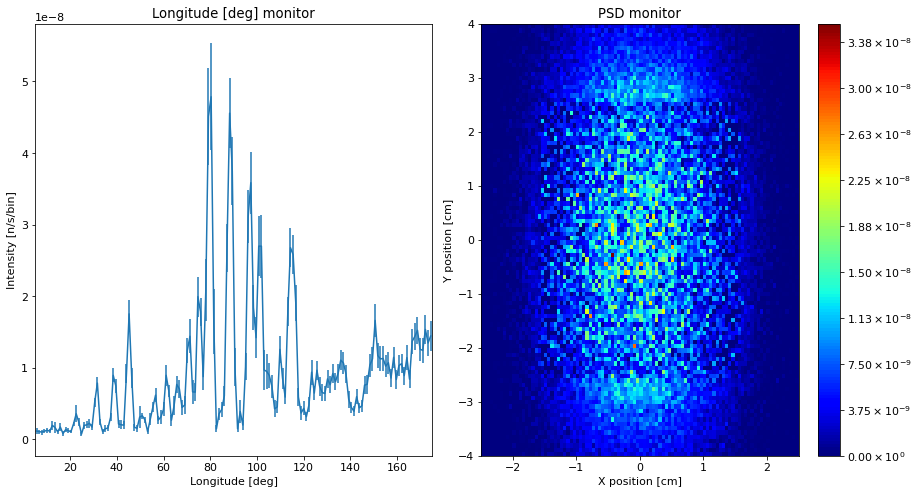

In [29]:
plotter.make_sub_plot(data)

### Adjusting plots
The McStasData objects contain preferences for how the data should be plotted, which can be modified using the functions module and the *name_plot_options* function. The function arguments are the name of the monitor component and a list of McStasData objects, then options are provided with the keyword arguments.

The following plot options are often useful:
- log [True or False] For plotting on logarithmic axis
- orders_of_mag [number] When using logarithmic plotting, limits the maximum orders of magnitudes shown
- left_lim [number] lower limit of plot x axis
- right_lim [number] upper limit of plot x axis
- bottom_lim [number] lower limit of plot y axis
- top_lim [number] upper limit of plot y axis
- colormap [string] name of matplotlib colormap to use

Plotting data with name banana
Plotting data with name monitor


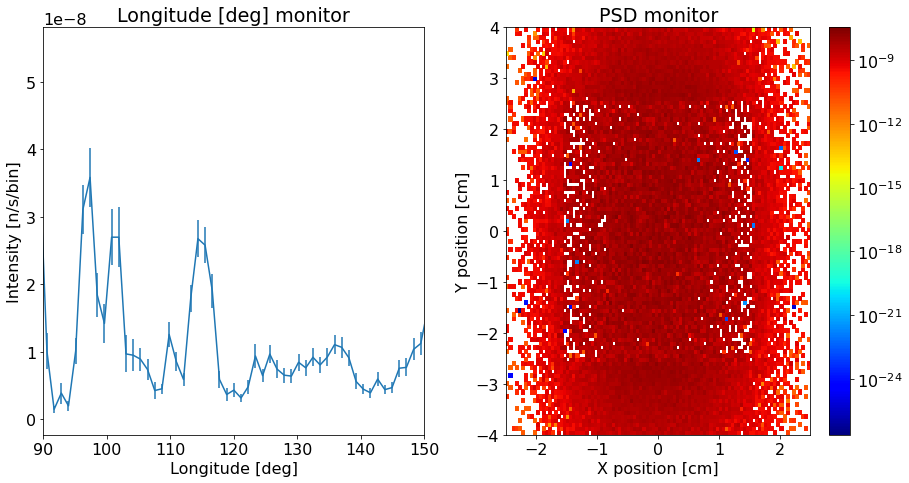

In [30]:
functions.name_plot_options("monitor", data, log=True)
functions.name_plot_options("banana", data, left_lim=90, right_lim=150)
plotter.make_sub_plot(data, fontsize=16)

## Behind the scenes 
McStasScript writes the instrument file and uses mcrun to compile and run it. The file can be found in the input_path selected when the instrument object were created. We can print it here to see what was done behind the scenes.

In [31]:
with open("run_folder/python_tutorial.instr") as file:
    data = file.read()
    print(data)

/********************************************************************************
* 
* McStas, neutron ray-tracing package
*         Copyright (C) 1997-2008, All rights reserved
*         Risoe National Laboratory, Roskilde, Denmark
*         Institut Laue Langevin, Grenoble, France
* 
* This file was written by McStasScript, which is a 
* python based McStas instrument generator written by 
* Mads Bertelsen in 2019 while employed at the 
* European Spallation Source Data Management and 
* Software Center
* 
* Instrument python_tutorial
* 
* %Identification
* Written by: Python McStas Instrument Generator
* Date: 12:59:09 on December 15, 2021
* Origin: ESS DMSC
* %INSTRUMENT_SITE: Generated_instruments
* 
* 
* %Parameters
* 
* %End 
********************************************************************************/

DEFINE INSTRUMENT python_tutorial (
wavelength = 2.8, // Wavelength in [Ang]
int order = 1 // Monochromator order, integer
)

DECLARE 
%{
double mono_Q = 1.714;
double waveve